Changing feature enginering

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max(
            )
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df_train = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train.csv')
df_test = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test.csv')
df_hist_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/historical_transactions_new.csv')
df_new_merchant_trans = pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_merchant_transactions_new.csv')

In [4]:
df_train=reduce_mem_usage(df_train)
df_test=reduce_mem_usage(df_test)
df_hist_trans=reduce_mem_usage(df_hist_trans)
df_new_merchant_trans=reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [6]:
train_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/train_month_lag_0.csv')
test_month_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/test_month_lag_0.csv')
hist_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/hist_month_lag_0.csv')
new_mech_lag_0=pd.read_csv('C:/Users/user/Documents/Salamat/ELO/new_mech_month_lag_0.csv')

In [7]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

I we can take weekofyear,day of week, weekend as extra parameter which I didn't. I am not sure if month diff is correct. Still confused about this issue

In [9]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    #df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    #df['month_diff'] += df['month_lag']
    
# We will use our extracted values for reference. From month_lag at zero (max)    
    
df_hist_trans['month_diff'] = ((hist_lag_0 - df_hist_trans['purchase_date']).dt.days)//30
df_hist_trans['month_diff'] += df_hist_trans['month_lag']

df_new_merchant_trans['month_diff'] = ((new_mech_lag_0 - df_new_merchant_trans['purchase_date']).dt.days)//30
df_new_merchant_trans['month_diff'] += df_new_merchant_trans['month_lag']


MemoryError: 

In [69]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']

#df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_hist_trans_group['hist_purchase_date_uptonow'] = (hist_lag_0 - df_hist_trans_group['hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
#del df_hist_trans_group;gc.collect()

In [70]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']

#df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (new_mech_lag_0 - df_hist_trans_group['new_hist_purchase_date_max']).dt.days

df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
#del df_hist_trans_group;gc.collect()

In [54]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.557617,-0.630859,54.0,2.347826,-243.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.557617,-0.571777,56.0,9.333333,-30.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.537109,-0.630859,0.0,0.000000,-59.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.545898,-0.571777,41.0,5.857143,-56.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.545898,-0.554688,57.0,1.583333,-60.0


In [71]:
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.557617,-0.630859,54.0,2.347826,-243.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.557617,-0.571777,56.0,9.333333,-30.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.537109,-0.630859,0.0,0.000000,-59.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.545898,-0.571777,41.0,5.857143,-56.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.545898,-0.554688,57.0,1.583333,-60.0


In [72]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [73]:


for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)


### We will change only elapsed time

In [74]:
df_train['elapsed_time'] = (train_month_lag_0 - df_train['first_active_month']).dt.days
df_test['elapsed_time'] = (test_month_lag_0 - df_test['first_active_month']).dt.days  

In [75]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [76]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()

14

In [77]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67123	valid_1's rmse: 3.74025
[200]	training's rmse: 3.59313	valid_1's rmse: 3.70891
[300]	training's rmse: 3.54246	valid_1's rmse: 3.69415
[400]	training's rmse: 3.50549	valid_1's rmse: 3.68598
[500]	training's rmse: 3.47594	valid_1's rmse: 3.68033
[600]	training's rmse: 3.45114	valid_1's rmse: 3.67682
[700]	training's rmse: 3.42928	valid_1's rmse: 3.6739
[800]	training's rmse: 3.4088	valid_1's rmse: 3.67228
[900]	training's rmse: 3.39074	valid_1's rmse: 3.67183
[1000]	training's rmse: 3.37399	valid_1's rmse: 3.67107
[1100]	training's rmse: 3.35744	valid_1's rmse: 3.67043
[1200]	training's rmse: 3.34163	valid_1's rmse: 3.67036
[1300]	training's rmse: 3.32582	valid_1's rmse: 3.67001
[1400]	training's rmse: 3.3111	valid_1's rmse: 3.66982
[1500]	training's rmse: 3.296	valid_1's rmse: 3.66984
Early stopping, best iteration is:
[1473]	training's rmse: 3.29997	valid_1's rmse: 3.66969
fold 1
Traini

3.6547007869635681

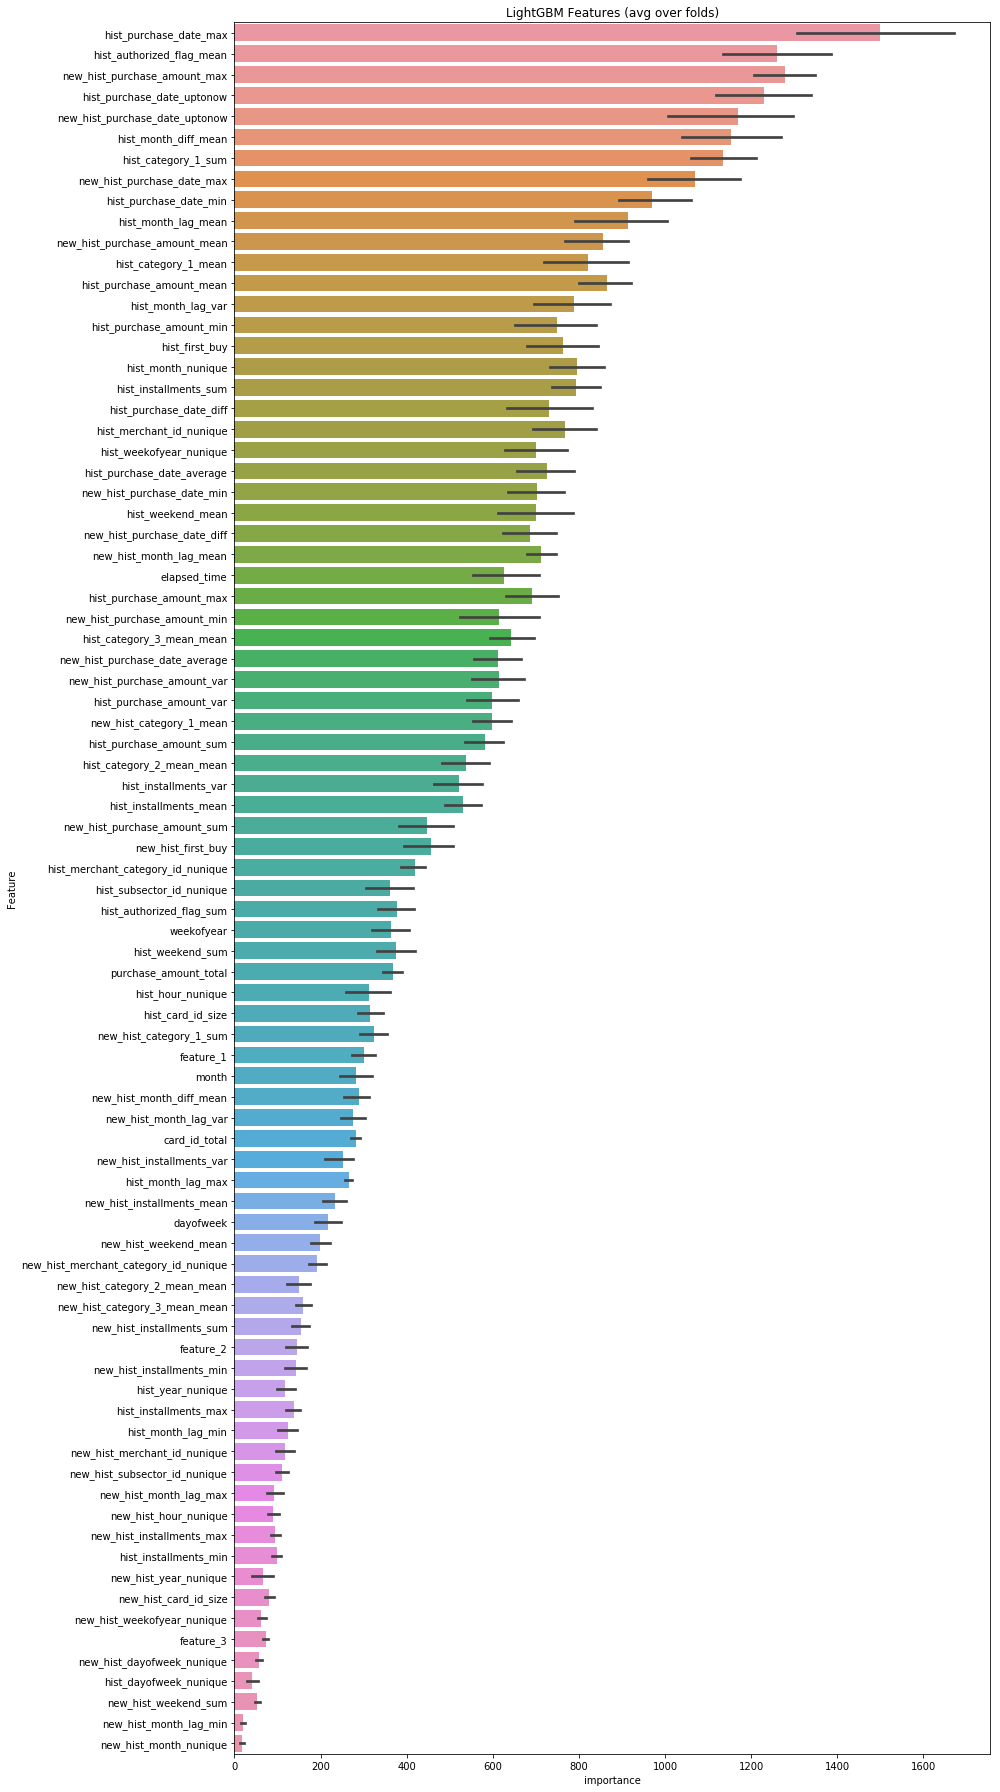

In [78]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_feature_eng_2_date.png')

In [79]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("chau_feature_engineering_3_date.csv", index=False)

**To be continued ...**

In [243]:
best_features.groupby('Feature').mean().sort_values('importance',ascending=False).to_csv('feature_importance2.csv')

In [83]:
df_train.to_csv('C:/Users/user/Documents/Salamat/ELO/train_new_lag.csv',index=False)

In [84]:
df_test.to_csv('C:/Users/user/Documents/Salamat/ELO/test_new_lag.csv',index=False)

In [88]:
best_features.groupby('Feature').mean().sort_values('importance',ascending=False).to_csv('best_features_dates.csv')